In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import requests
import json
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.utils.class_weight import compute_sample_weight

In [2]:
all_seasons = []

for season in range(2023, 2024):
    summary_url = f"https://api.nhle.com/stats/rest/en/skater/summary?limit=-1&cayenneExp=seasonId={season}{season+1}%20and%20gameTypeId=2"

    try:
        summary_resp = requests.get(summary_url)
        summary_resp.raise_for_status() 
        summary_json =  summary_resp.json()

        if summary_json['data']:
            df_summary = DataFrame(summary_json['data'])
            all_seasons.append(df_summary)
            df_summary['season'] = f"{season}-{season + 1}"
            print(f"Successfully fetched data for season {season}-{season+1}")
        else:
            print(f"No data returned for season {season}-{season + 1}")
        
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for season {season}-{season + 1}: {e}")

if all_seasons:
    nhl_api_df = pd.concat(all_seasons, ignore_index=True)
    nhl_api_df = nhl_api_df.groupby('playerId').agg({
            'playerId': 'first',
            'skaterFullName': 'first',
            'positionCode': 'first',
            'gamesPlayed': 'sum',
            'assists': 'sum',
            'otGoals': 'sum',
            'gameWinningGoals': 'sum',
        }).reset_index(drop = True)
    
print(nhl_api_df)

Successfully fetched data for season 2023-2024
     playerId     skaterFullName positionCode  gamesPlayed  assists  otGoals  \
0     8470600         Ryan Suter            D           82       15        0   
1     8470604        Jeff Carter            C           72        4        0   
2     8470610        Zach Parise            L           30        5        0   
3     8470613        Brent Burns            D           82       33        0   
4     8470621        Corey Perry            R           54       10        0   
..        ...                ...          ...          ...      ...      ...   
919   8484314       Jiri Smejkal            L           20        1        0   
920   8484321  Nikolas Matinpalo            D            4        0        0   
921   8484325    Waltteri Merela            C           19        0        0   
922   8484326        Patrik Koch            D            1        0        0   
923   8484911        Collin Graf            R            7        2      

In [3]:
nhl_api_df = nhl_api_df.loc[(nhl_api_df['positionCode'] != 'D') & (nhl_api_df['gamesPlayed'] >= 60)]
nhl_api_df = nhl_api_df.reset_index(drop = True)
nhl_api_df = nhl_api_df.fillna(0)

nhl_api_df.rename(columns = {'gameWinningGoals': 'game_winning_goals'}, inplace = True)
nhl_api_df.rename(columns = {'otGoals': 'ot_goals'}, inplace = True)
nhl_api_df.rename(columns = {'skaterFullName': 'Player'}, inplace = True)
nhl_api_df['regulation_game_winning'] = nhl_api_df['game_winning_goals'] - nhl_api_df['ot_goals']

In [4]:
goals_up_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
goals_down_one_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
tied_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"
total_url = "https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL"

In [5]:
urls = {
    "goals_up_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=u1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_up_by_one'),
    "goals_down_one": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=d1&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_down_by_one'),
    "tied": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=tied&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'goals_when_tied'),
    "total": ("https://www.naturalstattrick.com/playerteams.php?fromseason=20232024&thruseason=20232024&stype=2&sit=all&score=all&stdoi=std&rate=n&team=ALL&pos=F&loc=B&toi=0&gpfilt=none&fd=&td=&tgp=410&lines=single&draftteam=ALL", 'total_goals'),
}

dataframes = {}

for name, (url, new_column_name) in urls.items():
    df = pd.read_html(url, header=0, index_col=0, na_values=["-"])[0]
    df.rename(columns={'Goals': new_column_name}, inplace=True)
    dataframes[name] = df

goals_up_one_df = dataframes["goals_up_one"]
goals_down_one_df = dataframes["goals_down_one"]
goals_tied_df = dataframes["tied"]
total_df = dataframes["total"]

In [6]:
goals_up_one_df = goals_up_one_df[['Player', 'GP', 'goals_up_by_one']]
goals_down_one_df = goals_down_one_df[['Player', 'goals_down_by_one']]
goals_tied_df = goals_tied_df[['Player', 'goals_when_tied']]
total_df = total_df[['Player', 'total_goals', 'Shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'Rush Attempts', 'iCF', 'Rebounds Created']]

dfs_natural_stat = [goals_up_one_df, goals_down_one_df, goals_tied_df, total_df]

import functools as ft
merged_natural_stat = ft.reduce(lambda left, right: pd.merge(left, right, on='Player'), dfs_natural_stat)
merged_natural_stat = merged_natural_stat.loc[merged_natural_stat['GP'] >= 60]
merged_natural_stat.rename(columns={'Shots': 'shots'}, inplace=True)
merged_natural_stat.rename(columns={'Rush Attempts': 'rush_attempts'}, inplace=True)

In [7]:
natural_stat_names = ["Pat Maroon", "Alex Kerfoot", "Nicholas Paul", "Zach Sanford", "Alex Wennberg", "Mitchell Marner", "Zach Aston-Reese",  "Max Comtois", "Alexei Toropchenko", "Cameron Atkinson"]
nhl_names = ["Patrick Maroon", "Alexander Kerfoot", "Nick Paul", "Zachary Sanford", "Alexander Wennberg", "Mitch Marner", "Zachary Aston-Reese",  "Maxime Comtois", "Alexey Toropchenko", "Cam Atkinson"]
merged_natural_stat = merged_natural_stat.replace(natural_stat_names, nhl_names)

In [8]:
merged_natural_stat

,Player,GP,goals_up_by_one,goals_down_by_one,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rush_attempts,iCF,Rebounds Created
0,Jeff Carter,72,4,3,3,11,90,11.45,134,95,53,9,175,18
3,Joe Pavelski,82,7,4,10,27,194,28.18,261,232,130,7,329,34
4,Alex Ovechkin,79,7,2,7,31,272,29.89,395,245,83,17,605,64
5,Evgeni Malkin,82,3,6,6,27,199,23.56,280,218,82,6,401,47
7,Sidney Crosby,82,8,6,15,42,278,38.58,398,287,131,17,490,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549,Logan Cooley,82,2,2,8,20,151,16.52,217,147,57,8,284,21
556,Juraj Slafkovsky,82,2,4,5,20,152,21.56,226,198,98,5,314,27
564,Andrei Kuzmenko,72,3,5,6,22,121,19.29,197,182,97,4,265,40
566,Connor Bedard,68,2,6,9,22,206,23.82,299,226,69,17,401,34


In [9]:
nhl_api_df

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,regulation_game_winning
0,8470604,Jeff Carter,C,72,4,0,4,4
1,8470794,Joe Pavelski,C,82,40,1,4,3
2,8471214,Alex Ovechkin,L,79,34,1,5,4
3,8471215,Evgeni Malkin,C,82,40,0,2,2
4,8471675,Sidney Crosby,C,82,52,0,3,3
...,...,...,...,...,...,...,...,...
311,8483431,Logan Cooley,C,82,24,1,2,1
312,8483515,Juraj Slafkovsky,L,82,30,0,2,2
313,8483808,Andrei Kuzmenko,L,72,24,1,4,3
314,8484144,Connor Bedard,C,68,39,1,2,1


In [10]:
merged_clutch_goals = nhl_api_df.merge(merged_natural_stat, on = 'Player', how = 'left')

In [11]:
merged_clutch_goals

,playerId,Player,positionCode,gamesPlayed,assists,ot_goals,game_winning_goals,regulation_game_winning,GP,goals_up_by_one,...,goals_when_tied,total_goals,shots,ixG,iFF,iSCF,iHDCF,rush_attempts,iCF,Rebounds Created
0,8470604,Jeff Carter,C,72,4,0,4,4,72,4,...,3,11,90,11.45,134,95,53,9,175,18
1,8470794,Joe Pavelski,C,82,40,1,4,3,82,7,...,10,27,194,28.18,261,232,130,7,329,34
2,8471214,Alex Ovechkin,L,79,34,1,5,4,79,7,...,7,31,272,29.89,395,245,83,17,605,64
3,8471215,Evgeni Malkin,C,82,40,0,2,2,82,3,...,6,27,199,23.56,280,218,82,6,401,47
4,8471675,Sidney Crosby,C,82,52,0,3,3,82,8,...,15,42,278,38.58,398,287,131,17,490,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
311,8483431,Logan Cooley,C,82,24,1,2,1,82,2,...,8,20,151,16.52,217,147,57,8,284,21
312,8483515,Juraj Slafkovsky,L,82,30,0,2,2,82,2,...,5,20,152,21.56,226,198,98,5,314,27
313,8483808,Andrei Kuzmenko,L,72,24,1,4,3,72,3,...,6,22,121,19.29,197,182,97,4,265,40
314,8484144,Connor Bedard,C,68,39,1,2,1,68,2,...,9,22,206,23.82,299,226,69,17,401,34


In [12]:
null_rows = merged_clutch_goals[merged_clutch_goals.isnull().any(axis=1)]
print("Rows with null values:")
print(null_rows)

Rows with null values:
Empty DataFrame
Columns: [playerId, Player, positionCode, gamesPlayed, assists, ot_goals, game_winning_goals, regulation_game_winning, GP, goals_up_by_one, goals_down_by_one, goals_when_tied, total_goals, shots, ixG, iFF, iSCF, iHDCF, rush_attempts, iCF, Rebounds Created]
Index: []

[0 rows x 21 columns]


In [13]:
merged_clutch_goals.drop(columns = 'GP', axis = 1, inplace = True)

In [14]:
columns = ['ot_goals', 'regulation_game_winning', 'assists', 'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts','iCF']
for column in columns:
    per_game_string = f"{column}_per_game"
    merged_clutch_goals[per_game_string] = merged_clutch_goals[column] / merged_clutch_goals['gamesPlayed']


In [15]:
merged_clutch_goals['clutch_score'] =  merged_clutch_goals['goals_when_tied_per_game'] + merged_clutch_goals['goals_down_by_one_per_game'] + merged_clutch_goals['goals_up_by_one_per_game'] + merged_clutch_goals['regulation_game_winning_per_game'] 

In [16]:
merged_clutch_goals['clutch_score'] *= 10
merged_clutch_goals['clutch_score_rank']  = merged_clutch_goals['clutch_score'].rank(ascending = False)
merged_clutch_goals['clutch_score'] = merged_clutch_goals['clutch_score'].apply(lambda x: round(x, 2))
merged_clutch_goals.sort_values('clutch_score_rank', inplace = True)
merged_clutch_goals[['Player','clutch_score', 'clutch_score_rank']].head(50)

,Player,clutch_score,clutch_score_rank
205,Auston Matthews,6.91,1.0
138,Sam Reinhart,6.22,2.0
150,David Pastrnak,5.49,3.0
166,Kyle Connor,5.38,4.0
156,Brayden Point,4.94,5.0
197,Kirill Kaprizov,4.93,6.0
96,Filip Forsberg,4.88,7.0
173,Sebastian Aho,4.74,8.0
124,Nathan MacKinnon,4.63,9.5
193,Artemi Panarin,4.63,9.5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


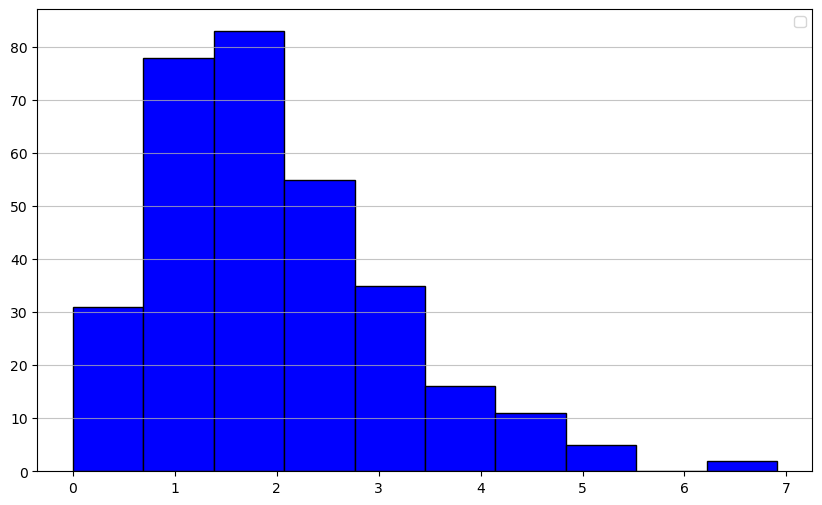

In [17]:
plt.figure(figsize=(10, 6))
plt.hist(merged_clutch_goals['clutch_score'], color='blue', edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

In [18]:
threshold_elite = merged_clutch_goals['clutch_score'].quantile(0.85)
threshold_high = merged_clutch_goals['clutch_score'].quantile(0.7)
threshold_average = merged_clutch_goals['clutch_score'].quantile(0.5)


def label_clutchness(row):
    clutch_score = row['clutch_score']
    if clutch_score >= threshold_elite:
        return 1
    else:
        return 0

merged_clutch_goals['clutch_label'] = merged_clutch_goals.apply(label_clutchness, axis=1)

In [19]:
merged_clutch_goals['clutch_label'].value_counts()

clutch_label
0    267
1     49
Name: count, dtype: int64

In [20]:
x_var = ['shots_per_game', 'ixG_per_game', 'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game', 'rush_attempts_per_game']
y_var = 'clutch_label'

X = merged_clutch_goals[x_var]
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.2, stratify = y)
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss')
xgb_model.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [21]:
skf = StratifiedKFold(n_splits=10)

scoring = ['accuracy', 'precision', 'recall', 'f1', 'average_precision']

scores = cross_validate(xgb_model, X, y, cv = skf, scoring = scoring)

df_scores = pd.DataFrame.from_dict(scores)

df_scores.mean()

fit_time                  0.102834
score_time                0.033112
test_accuracy             0.867641
test_precision            0.810000
test_recall               0.565000
test_f1                   0.599678
test_average_precision    0.801840
dtype: float64

C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "C:\Users\jivrajs3\AppData\Local\anaconda3\Lib\site-packages\xgboost\sklearn.py", line 1491, in fit
    raise

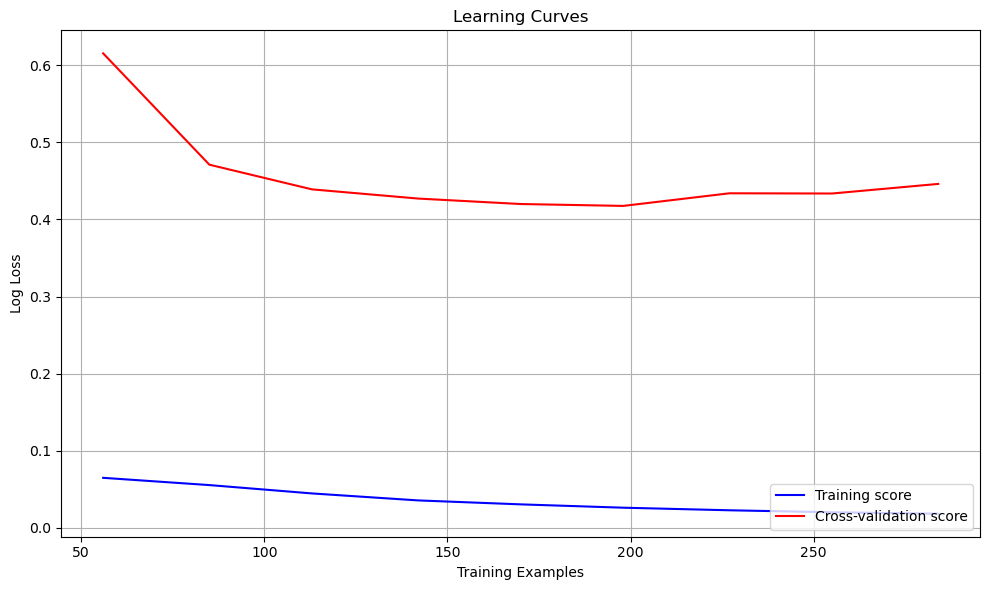

In [22]:
cv = StratifiedKFold(n_splits=10)

train_sizes = np.linspace(0.1, 1.0, 10)
    
train_sizes, train_scores, valid_scores = learning_curve(
    xgb_model, X, y, 
    cv=cv,
    n_jobs=-1,
    train_sizes=train_sizes,
    scoring='neg_log_loss',
)

train_mean = -np.mean(train_scores, axis=1)
train_std = -np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = -np.std(valid_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')

plt.title(f'Learning Curves')
plt.xlabel('Training Examples')
plt.ylabel('Log Loss')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

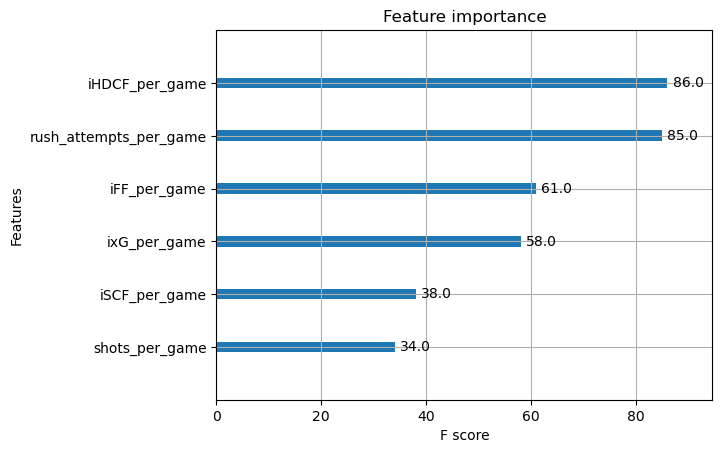

In [23]:
plot_importance(xgb_model)
plt.show()

In [24]:
merged_clutch_goals.columns

Index(['playerId', 'Player', 'positionCode', 'gamesPlayed', 'assists',
       'ot_goals', 'game_winning_goals', 'regulation_game_winning',
       'goals_up_by_one', 'goals_down_by_one', 'goals_when_tied',
       'total_goals', 'shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts',
       'iCF', 'Rebounds Created', 'ot_goals_per_game',
       'regulation_game_winning_per_game', 'assists_per_game',
       'goals_up_by_one_per_game', 'goals_down_by_one_per_game',
       'goals_when_tied_per_game', 'shots_per_game', 'ixG_per_game',
       'iFF_per_game', 'iSCF_per_game', 'iHDCF_per_game',
       'rush_attempts_per_game', 'iCF_per_game', 'clutch_score',
       'clutch_score_rank', 'clutch_label'],
      dtype='object')

In [129]:
x_var = ['shots', 'ixG', 'iFF', 'iSCF', 'iHDCF', 'rush_attempts', 'assists', 'iCF', 'Rebounds Created']
X_adjusted = merged_clutch_goals[x_var]
y_var = 'clutch_label'
y = merged_clutch_goals[y_var]

train_x, test_x, train_y, test_y = train_test_split(
    X_adjusted, 
    y, 
    test_size=0.15, 
    stratify=y,
)


class_weights = compute_sample_weight(class_weight='balanced', y=train_y)

xgb_model_adjusted = xgb.XGBClassifier(n_estimators = 100, eval_metric = 'logloss', seed = 42)
xgb_model_adjusted.fit(train_x, train_y, sample_weight = class_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [131]:
from skopt import BayesSearchCV
import xgboost as xgb
import time
import math
from skopt.space import Integer, Real
from scipy.stats import randint, uniform
from skopt.space import Real, Integer, Categorical

param_grid = {
    'max_depth': Integer(2,5),  # Reduced from 5 to limit complexity
    'min_child_weight': Integer(2,3),  # Increased to prevent overfitting
    'n_estimators': Integer(700, 1000),  # Narrowed based on your curves
    'learning_rate': Real(0.03, 0.04),  # Slightly lower than current ~0.14
    'reg_alpha': Real(0.75, 1.9),  # Reduced from current ~1.87
    'reg_lambda': Real(0.75, 1.9),  # Reduced from current ~2.92
    'subsample': Real(0.7, 1),  # Slightly higher than current ~0.74
    'colsample_bytree': Real(0.7, 1)  # Higher than current ~0.64
}


def learning_rate_schedule(iteration):
    return 0.1 * (0.99 ** iteration)

# Modified fit parameters
fit_params = {
    'early_stopping_rounds': 35,  # More aggressive stopping
}


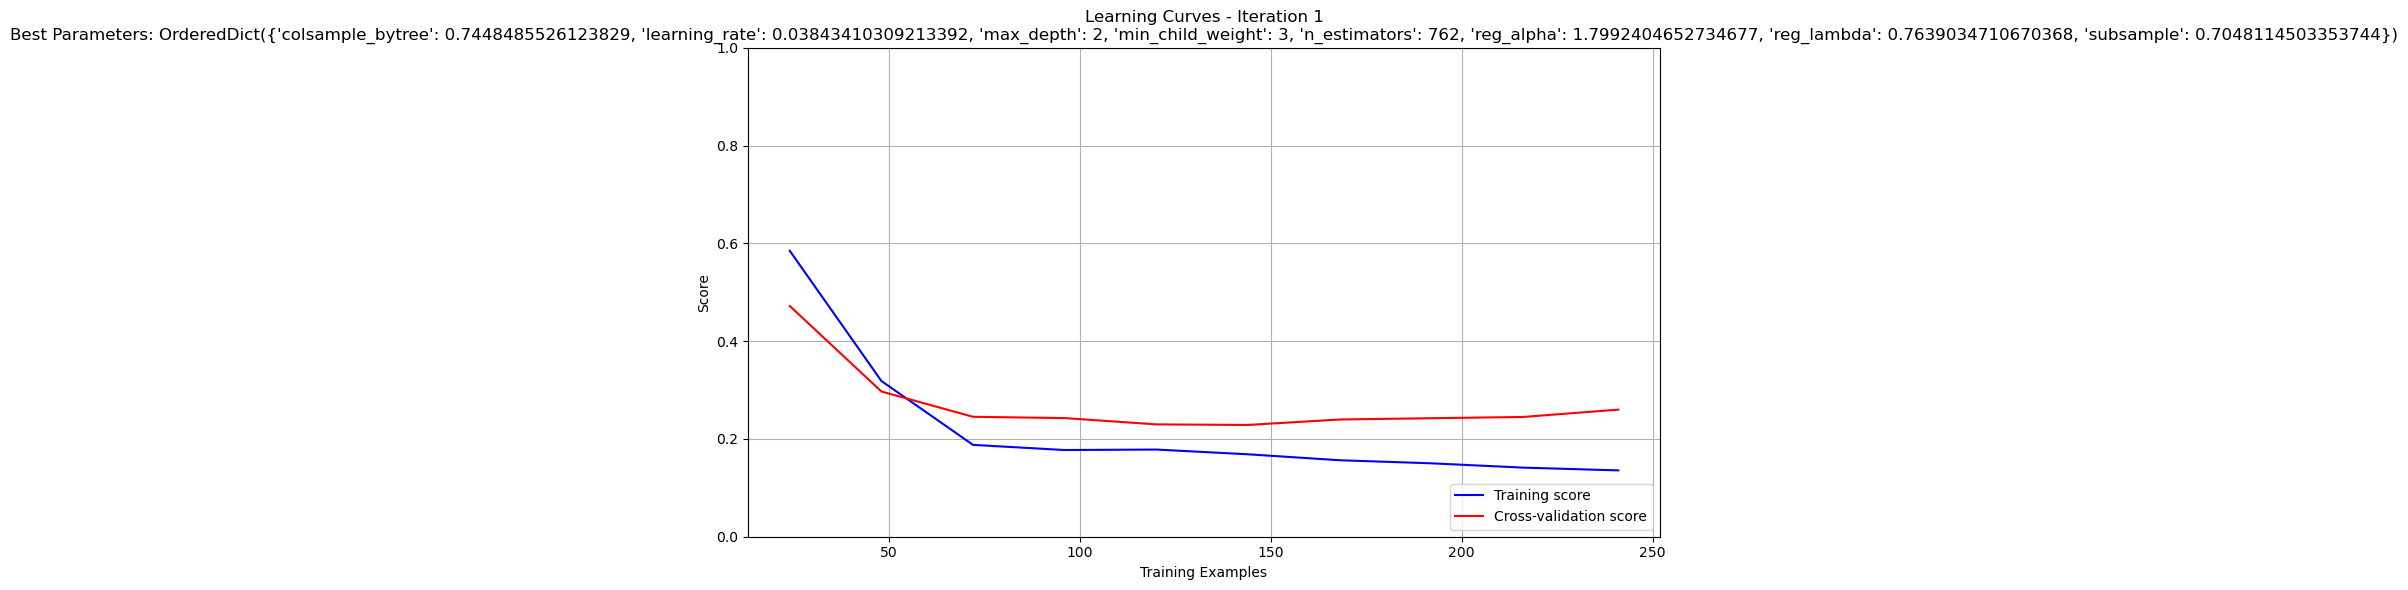

0.8541666666666666
0.5
0.5714285714285714
0.5333333333333333


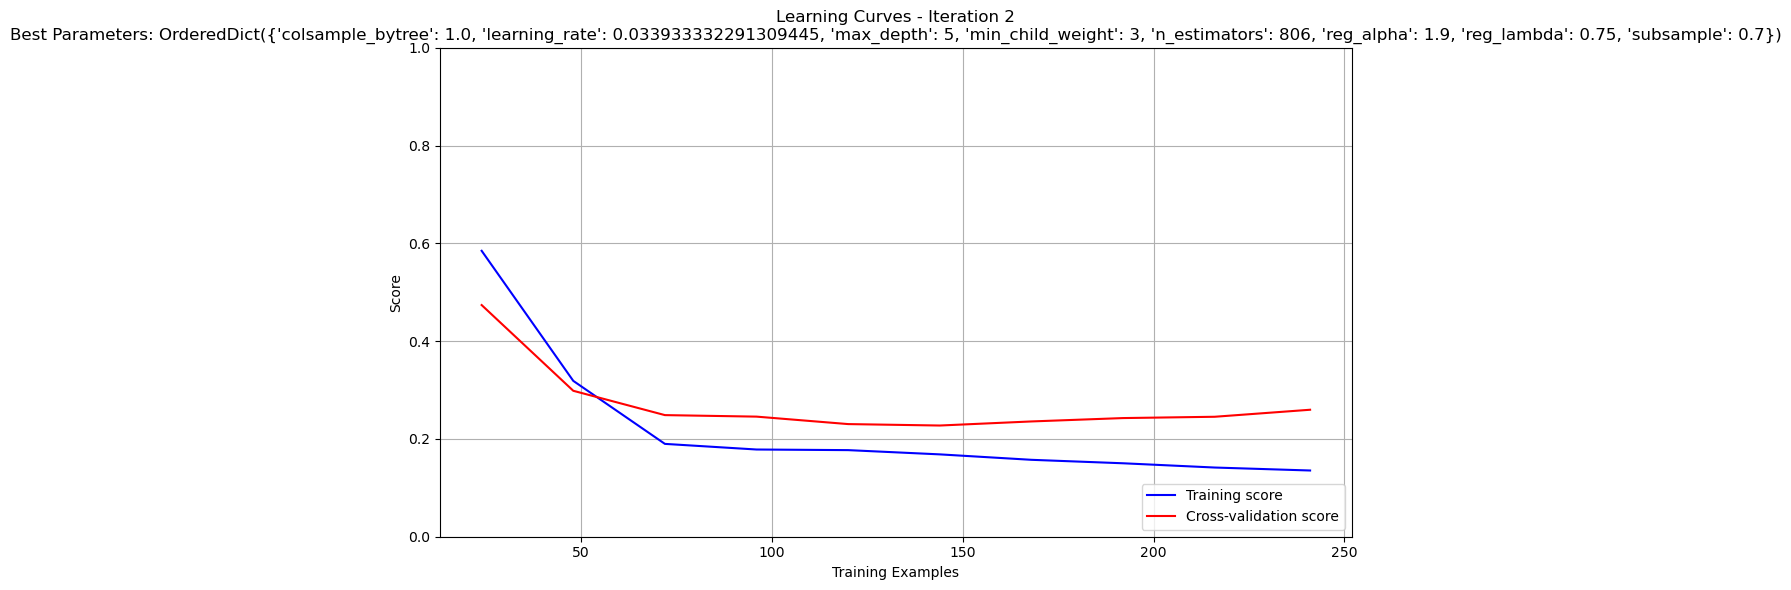

0.8541666666666666
0.5
0.5714285714285714
0.5333333333333333


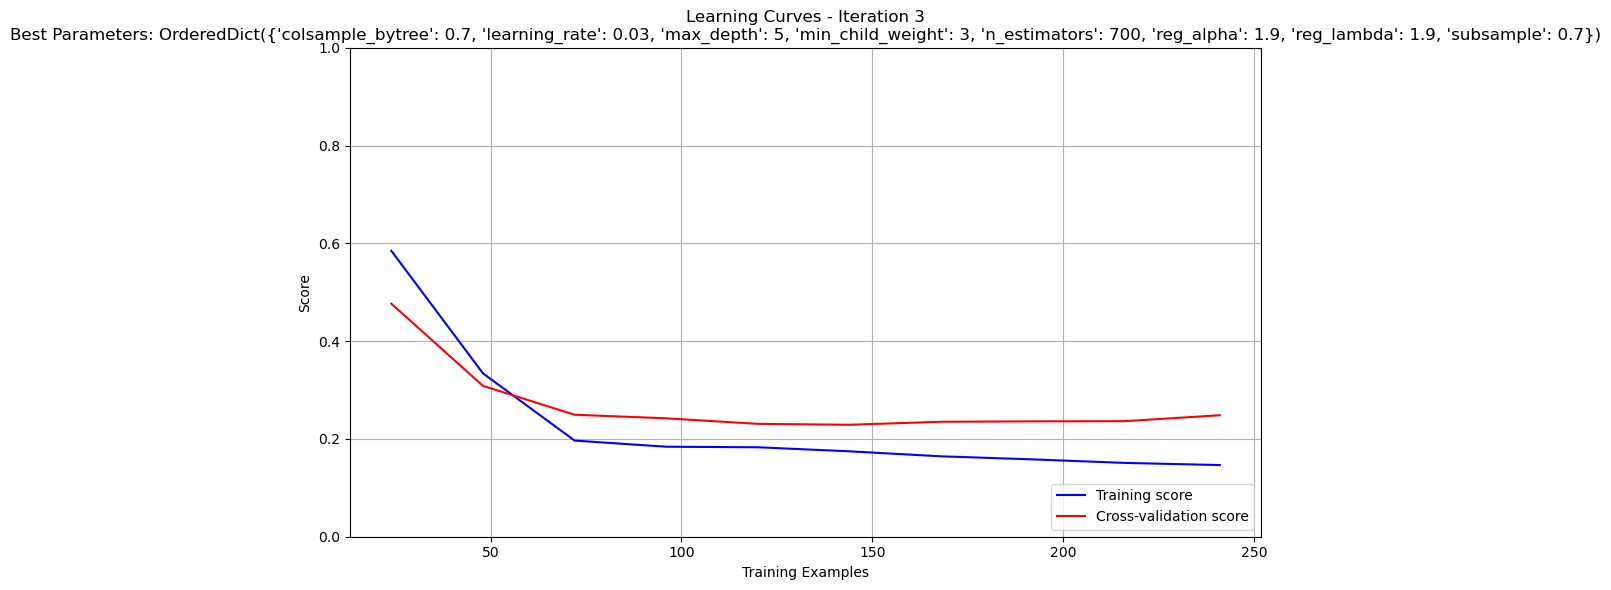

0.8541666666666666
0.5
0.5714285714285714
0.5333333333333333


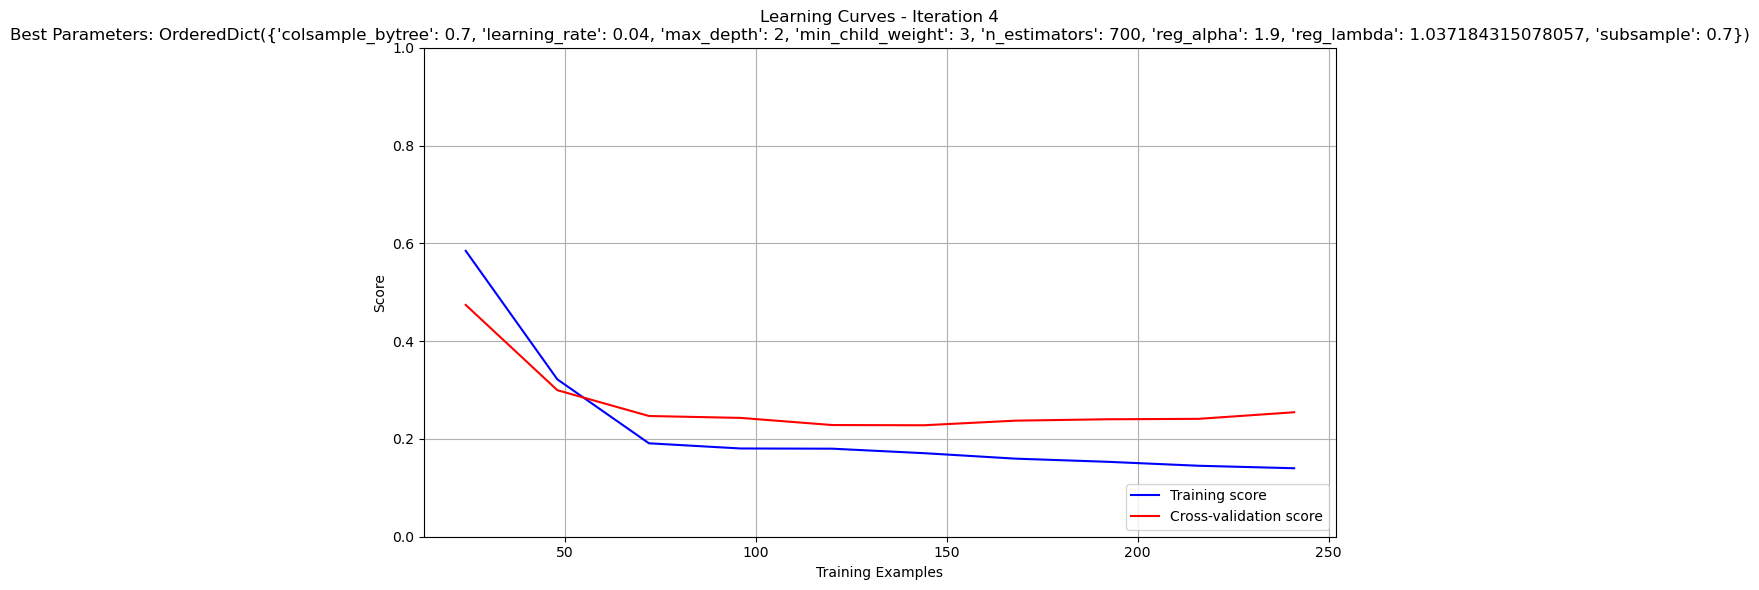

0.8541666666666666
0.5
0.5714285714285714
0.5333333333333333


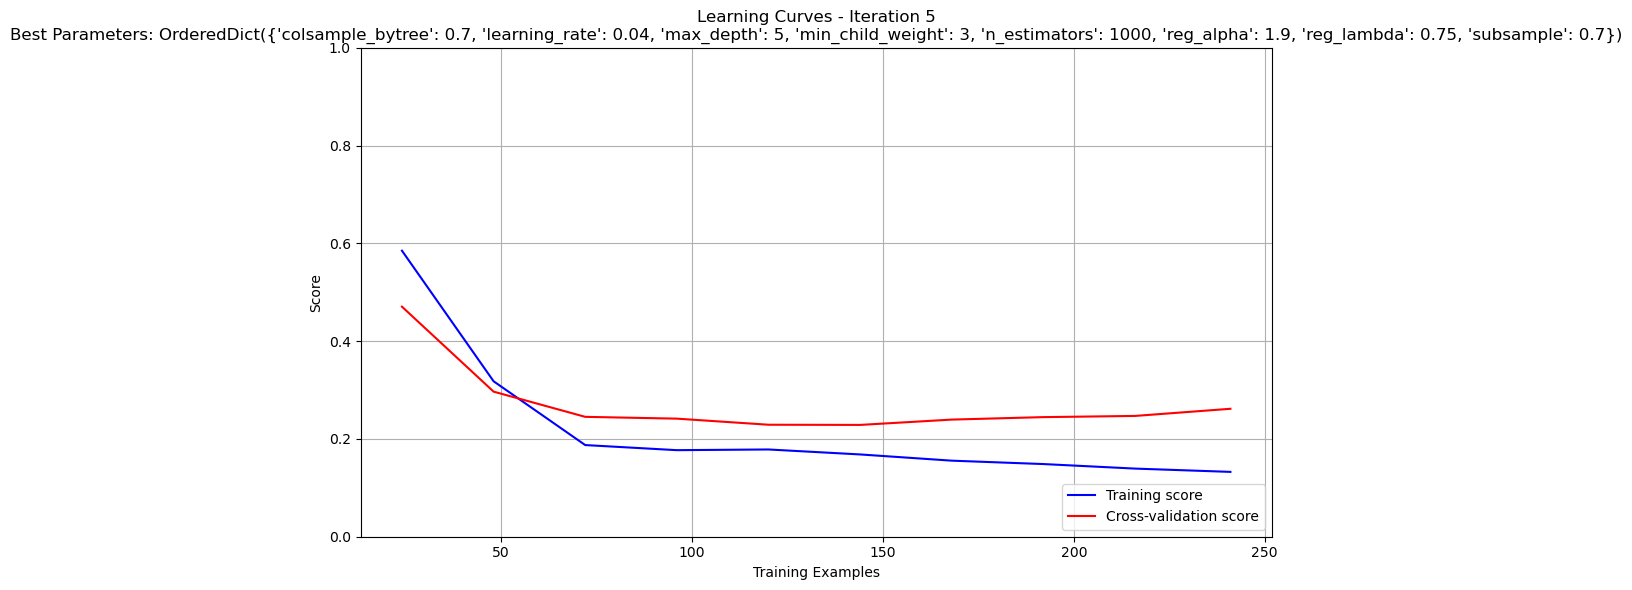

0.8541666666666666
0.5
0.5714285714285714
0.5333333333333333
Average Accuracy: 0.8541666666666666
Average Precision: 0.5
Average Recall: 0.5714285714285714
Average F1 Score: 0.5333333333333333
Averaged Hyperparameters:
colsample_bytree      0.768970
learning_rate         0.036473
max_depth             3.800000
min_child_weight      3.000000
n_estimators        793.600000
reg_alpha             1.879848
reg_lambda            1.040218
subsample             0.700962
dtype: float64


In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from skopt import BayesSearchCV
import xgboost as xgb

cv = StratifiedKFold(n_splits=10)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
best_hyperparams_list = []

def plot_learning_curves(estimator, X, y, cv, iteration, title):

    train_sizes = np.linspace(0.1, 1.0, 10)
    
    # Calculate learning curves
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, 
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='neg_log_loss'
    )

    # Calculate mean and std
    train_mean = -np.mean(train_scores, axis=1)
    train_std = -np.std(train_scores, axis=1)
    valid_mean = -np.mean(valid_scores, axis=1)
    valid_std = -np.std(valid_scores, axis=1)
    
    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue')
    
    plt.plot(train_sizes, valid_mean, label='Cross-validation score', color='red')
    
    plt.title(f'Learning Curves - Iteration {iteration}\n{title}')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()


for _ in range(5):
    rs = np.random.randint(1, 1000)

    random_search = BayesSearchCV(xgb_model_adjusted, param_grid, cv=cv, n_iter=20, scoring= ['recall'], refit='recall', random_state=rs, n_jobs = -1, fit_params = fit_params)

    new = random_search.fit(train_x,train_y)

    xgb_best_model = new.best_estimator_
    
    title = f'Best Parameters: {random_search.best_params_}'
    plot_learning_curves(xgb_best_model, train_x, train_y, cv, _+1, title)

  
    y_pred = xgb_best_model.predict(test_x)
    y_pred_prob = xgb_best_model.predict_proba(test_x)  # Probabilities for all classes

    # Metrics
    accuracy = accuracy_score(test_y, y_pred)
    precision = precision_score(test_y, y_pred, zero_division=0)
    recall = recall_score(test_y, y_pred)
    f1 = f1_score(test_y, y_pred)
    print(accuracy)
    print(precision)
    print(recall)
    print(f1)

    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

    best_hyperparams_list.append(random_search.best_params_)

print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))
print("Average F1 Score:", np.mean(f1_list))

hyperparams_df = pd.DataFrame(best_hyperparams_list)
averaged_hyperparams = hyperparams_df.mean()
print("Averaged Hyperparameters:")
print(averaged_hyperparams)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(test_y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot()
plt.suptitle('Confusion Matrix for XGBoost')
plt.show()

In [89]:
results = pd.DataFrame({'Actual': test_y, 'Predicted': y_pred})
misclassifications = results[results['Actual'] == 1]
print(misclassifications)

     Actual  Predicted
61        1          0
150       1          1
141       1          1
139       1          1
28        1          0
172       1          1
138       1          1


In [59]:
merged_clutch_goals.loc[49]

playerId                                  8475745
Player                              Charlie Coyle
positionCode                                    C
gamesPlayed                                    82
assists                                        35
ot_goals                                        0
game_winning_goals                              5
regulation_game_winning                         5
goals_up_by_one                                 4
goals_down_by_one                               5
goals_when_tied                                10
total_goals                                    25
shots                                         146
ixG                                         20.08
iFF                                           209
iSCF                                          168
iHDCF                                         104
rush_attempts                                  16
iCF                                           254
ot_goals_per_game                             0.0
